# 13 Reverse Quantum Annealing with Portfolio Optimization Problem as an example

## ポートフォリオ最適化問題
  資産運用して投資活動を行うとき、できるだけリスクを回避しながら大きな収益を実現させたい。なので、収益が限定的であるが、リスクが小さい（ないし全くない）資産と見込める収益が大きい分リスクも大きい資産を組み合わせてポートフォリオを作って分散投資を行うのが一般的な戦略になる。

  この時、与えられた一定のリスクでは最大利益を実現したい、または同じ利益を実現する場合できるだけ小さいリスクを取るには、最適なポートフォリオを選ぶ必要がある。現在、よく利用される手法はMarkowitzによる現代ポートフォリオ理論(Modern Portfolio Theory)であり、ポートフォリオを構成する銘柄の間の相関を考慮して、その共分散を最小にさせるような手法になる[1]。
  $$
  \min \sum_{i=1}^{N}\sum_{j=1}^{N}w_{i}w_{j}\sigma_{ij}; \quad \sum_{i=1}^{N}W_{i}=1; \quad \sum_{i=1}^{N}W_{i}\mu_{i}=R
  $$
  ただし、$w_{i}$は各銘柄がポートフォリオ内を占める重みで、$\sigma_{ij}$は銘柄間の共分散である。$\mu_{i}$は各銘柄の期待収益で、$R$はこのポートフォリオの総収益になる。



### Sharpe Ratio

## Reverse Quantum Annealingとは

## Open Jijにおける実装

実際に実装を行う前に、まずは実験用データの生成を行う。
論文[1]にある方法に従って、与えられた初期値を用いて、ブラウン運動によるチャートを生成する。

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Magic numbers to generate assets
rho = 0.1 # input uniform correlation
mu = 0.075 # expected value
sigma = 0.15 # volatility/standard error
r0 = 0.015 # no risk return

付録Aによって、各時刻においてチャートの運動は前の時刻の運動によって
$$
S(t_{n+1})=S(t_n)\exp(\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma Z_n\sqrt{\Delta t}
$$
のように与えられる。ここの$Z_n$はcholesky分解で作られた一様相関行列$\rho$を従う多変量正規分布になる。

それを実行して適当にチャートをプロットして様子を確認する。全体として初期値から広がっていくが、一部銘柄が大きく上昇または降下するのも確認できる。

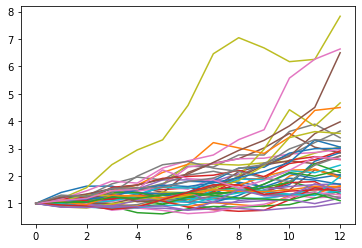

In [20]:
def createZvariables(N, rho):
  rho_mat = np.full((N,N), rho)
  rho_mat[range(N), range(N)] = 1.0
  rho_chole = np.linalg.cholesky(rho_mat)
  zNs_temp = np.random.normal(0, 1, (10000, N))
  zNs = zNs_temp @ rho_chole
  return zNs

def GetNextSt(St, mu, sigma, zN):
  Deltat = 1
  #zN = random.choice(zNs)
  scale = np.exp((mu-0.5*sigma*sigma)*Deltat + sigma*zN*np.sqrt(Deltat))
  NextSt = St * scale
  return NextSt

Nassets = 48
chart = list()
ZList = list()
Zvariables = createZvariables(Nassets, rho)
Zlabels = random.sample([x for x in range(10000)], 12)
for label in Zlabels:
  ZList.append(Zvariables[label])
for iasset in range(Nassets):
  chart_asset = [1.0]
  for month in range(12):
    chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
  chart.append(chart_asset)
  #print(chart_asset)
  plt.plot(list(range(13)), chart_asset)
plt.show()

銘柄のチャートを生成できたので、Sharpe Ratioを計算する。ここ結果を評価するに使うのは実現Sharpe Ratioで、無リスク利回り率を超過した超過収益率の平均と超過収益率の標準偏差で求められる。チャートを確認するとき分かったように、銘柄数が少ない場合は偶然による偏りが大きいので、銘柄を10回生成してその平均Shape Ratioの確認をする。
結果として、銘柄の平均Sharpe Ratioが概ね0.4付近になるのを確認できる。

In [35]:

def CreateAssets(Nassets): 
  chart = list()
  ZList = list()
  Zvariables = createZvariables(Nassets, rho)
  Zlabels = random.sample([x for x in range(10000)], 12)
  for label in Zlabels:
    ZList.append(Zvariables[label])
  for iasset in range(Nassets):
    chart_asset = [1.0]
    for month in range(12):
      chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
    chart.append(chart_asset)
  return chart

#def CalculateSharpeRatio(asset):
#  monthly_log_return = list()
#  #monthly_return = list()
#  for month in range(12):
#    valueChange = asset[month+1]/asset[month] - 1.0 # 毎月の収益
#    log_return = np.log(valueChange+1.0)
#    monthly_log_return.append(log_return)
#    #monthly_return.append(valueChange)
#
#  mean_log_return = np.mean(monthly_log_return)
#  log_volatility = np.std(monthly_log_return,ddof=1)
#
#  #mean_return = np.mean(monthly_return)
#  #volatility = np.std(monthly_return,ddof=1)
#
#
#  return (mean_log_return-np.log(1+r0))/log_volatility
#  #return (mean_return-r0)/volatility
#

def CalculateSharpeRatio(asset):
    monthly_return = list()
    for month in range(12):
      valueChange = asset[month+1]/asset[month] - 1.0 - r0
      monthly_return.append(valueChange)

    annualized_excess_return = np.mean(monthly_return)
    volatility = np.std(monthly_return, ddof=1)

    return(annualized_excess_return/volatility)

def CalculateSharpeRatio_log(asset):
  monthly_log_return = list()
  for month in range(12):
    valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(valueChange)
  mean_log_return = np.mean(monthly_log_return)
  volatility = np.std(monthly_log_return, ddof=1)

  return (mean_log_return-r0)/volatility

def CalculateSharpeRatio_2(asset):
  monthly_log_return = list()
  monthly_return = list()
  for month in range(11):
    log_valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(log_valueChange)
    valueChange = asset[month+1]/asset[month] - 1.0
    monthly_return.append(valueChange)
  annualized_excess_return = np.mean(monthly_return)
  volatility = np.std(monthly_log_return, ddof=1)

allmean = 0
for ntry in range(50):
  Chart = CreateAssets(48)
  mean_SR = 0.0
  n = 0.
  for asset in Chart:
    assetSR = CalculateSharpeRatio(asset)
    mean_SR = ((mean_SR*n)+assetSR) / (n+1)
    n+=1
  print("SubSet "+ str(ntry)+ " average Sharpe Ratio: " + str(mean_SR))
  allmean = ((allmean*ntry)+mean_SR) / (ntry+1)
  print("Average Sharpe Ratio of all generated: "+ str(allmean))

SubSet 0 average Sharpe Ratio: 0.4660493394730503
Average Sharpe Ratio of all generated: 0.4660493394730503
SubSet 1 average Sharpe Ratio: 0.4841058068892592
Average Sharpe Ratio of all generated: 0.47507757318115473
SubSet 2 average Sharpe Ratio: 0.40007192043626755
Average Sharpe Ratio of all generated: 0.450075688932859
SubSet 3 average Sharpe Ratio: 0.36755934808691787
Average Sharpe Ratio of all generated: 0.4294466037213737
SubSet 4 average Sharpe Ratio: 0.35844383880419284
Average Sharpe Ratio of all generated: 0.4152460507379375
SubSet 5 average Sharpe Ratio: 0.4539726194924263
Average Sharpe Ratio of all generated: 0.4217004788636857
SubSet 6 average Sharpe Ratio: 0.3638999442574069
Average Sharpe Ratio of all generated: 0.4134432596342173
SubSet 7 average Sharpe Ratio: 0.39386263807578253
Average Sharpe Ratio of all generated: 0.41099568193941294
SubSet 8 average Sharpe Ratio: 0.3540752212192351
Average Sharpe Ratio of all generated: 0.40467118630383764
SubSet 9 average Sharp

銘柄の確認ができてから、作られたポートフォリオ全体のパフォーマンスを確認する、ここでは全銘柄が同じ重みで選ばれるシナリオで銘柄全体のSharpe Ratioを計算しているが、48銘柄の場合で論文の結果「平均1.4、25パーセント分位0.5、75パーセント分位2.1」を再現できていない。（TODO）

In [36]:
Nassets = 48
SR_list = list()

for ntry in range(10):
    Chart = CreateAssets(Nassets)
    portfolioChart = np.mean(Chart, axis=0)
    portfolioSR = CalculateSharpeRatio(portfolioChart)
    SR_list.append(portfolioSR)
    print(portfolioSR)
    print(np.mean(SR_list), np.percentile(SR_list, [25,75]))


1.219652972594986
1.219652972594986 [1.21965297 1.21965297]
1.4162610538614393
1.3179570132282126 [1.26880499 1.36710903]
1.001325529615396
1.2124131853572737 [1.11048925 1.31795701]
1.1292423439294368
1.1916204750003145 [1.09726314 1.26880499]
1.3851492668177274
1.230326233363797 [1.12924234 1.38514927]
0.8655063801525176
1.1695229244952505 [1.03330473 1.34377519]
1.2491571485319544
1.1808992422147797 [1.06528394 1.31715321]
1.1438694006027557
1.1762705120132766 [1.09726314 1.28315518]
0.9947605940389158
1.1561027433494586 [1.00132553 1.24915715]
1.0261976398928638
1.1431122330037993 [1.00754356 1.2417811 ]


銘柄生成ができたので、比較用の古典アルゴリズムの実装とQUBO行列に必要な相関行列などの準備を行う。ここで、論文に従い、連続量を持つ相関行列を離散的な利得量で評価するように変換した。また、相関自体もチャートの形の相関ではなく、生成した各銘柄毎月のlog-returnの相関で計算した。

In [157]:
import heapq
import pandas as pd
import copy

def CreateCorrMat(Chart):
    assets = list()
    for iasset in range(len(Chart)):
        returns = list()
        for month in range(12):
            log_return = np.log(Chart[iasset][month+1]/Chart[iasset][month])
            returns.append(log_return)
        assets.append(returns)
    Chart_pd = pd.DataFrame(assets).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    return pairwise_corr

def SRBucket(SR_list):
    Buckets=sorted(SR_list)
    Buckets.reverse()
    GroupedList = list(np.array_split(Buckets,11))
    for i in range(len(SR_list)):
        if   SR_list[i] in GroupedList[0]: SR_list[i]=15
        elif SR_list[i] in GroupedList[1]: SR_list[i]=12
        elif SR_list[i] in GroupedList[2]: SR_list[i]=9
        elif SR_list[i] in GroupedList[3]: SR_list[i]=6
        elif SR_list[i] in GroupedList[4]: SR_list[i]=3
        elif SR_list[i] in GroupedList[5]: SR_list[i]=0
        elif SR_list[i] in GroupedList[6]: SR_list[i]=-3
        elif SR_list[i] in GroupedList[7]: SR_list[i]=-6
        elif SR_list[i] in GroupedList[8]: SR_list[i]=-9
        elif SR_list[i] in GroupedList[9]: SR_list[i]=-12
        elif SR_list[i] in GroupedList[10]: SR_list[i]=-15

def CorrelationBucket(Corr):
    for i in range(len(Corr)):
        for j in range(len(Corr)):
            if Corr[i][j] >= -1.00 and  Corr[i][j] < -0.25: Corr[i][j] = -5
            elif Corr[i][j] >= -0.25 and  Corr[i][j] < -0.15: Corr[i][j] = -3
            elif Corr[i][j] >= -0.15 and  Corr[i][j] < -0.05: Corr[i][j] = -1
            elif Corr[i][j] >= -0.05 and  Corr[i][j] < 0.05: Corr[i][j] = 0
            elif Corr[i][j] >= 0.05 and  Corr[i][j] < 0.15: Corr[i][j] = 1
            elif Corr[i][j] >= 0.15 and  Corr[i][j] < 0.25: Corr[i][j] = 3
            elif Corr[i][j] >= 0.25 and  Corr[i][j] < 1.00: Corr[i][j] = 5

def hi(SR_list, Corr, i):
    h = 0.5*SR_list[i] + np.sum(Corr[i])
    return h

def jij(Corr, i, j):
    return 1./4.*Corr[i][j]


def CreateCorrMat(Chart):
    assets = list()
    for iasset in range(len(Chart)):
        returns = list()
        for month in range(12):
            log_return = np.log(Chart[iasset][month+1]/Chart[iasset][month])
            returns.append(log_return)
        assets.append(returns)
    Chart_pd = pd.DataFrame(assets).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    return pairwise_corr

def GenerateRandomSolution(Nassets):
    Solution = np.random.randint(2, size=Nassets)
    for i in range(Nassets):
        Solution[i] = 2*Solution[i] - 1
    return Solution

def EvaluateSolution(Solution,Chart):
    selected_assets = list()
    for i in range(len(Solution)):
        if Solution[i] == 1:
            selected_assets.append(Chart[i])
    portfolioChart = np.mean(selected_assets, axis=0)
    portfolioSR = CalculateSharpeRatio(portfolioChart)
    return portfolioSR

def CreateDescendant(Ancestor, Ndescendants, MaxMutation):
    n = 0
    index_list = range(len(Ancestor))
    Descendants = list()
    while n < Ndescendants:
        Nmutaion = np.random.randint(MaxMutation)
        Place_to_change = np.random.choice(index_list, size=Nmutaion, replace=False)
        Descendant = list()
        for place in Place_to_change:
            Descendant = copy.deepcopy(Ancestor)
            Descendant[place] = Ancestor[place] * -1
            Descendants.append(Descendant)
        n += 1
    return Descendants


Nassets = 48

Chart = CreateAssets(Nassets)
#Chart_pd = pd.DataFrame(Chart).T
#pairwise_corr = Chart_pd.corr(method='pearson')
pairwise_corr = CreateCorrMat(Chart)
SR_list = list()
for asset in Chart:
    SR_list.append(CalculateSharpeRatio(asset))

#Bucketの翻訳
SRBucket(SR_list)
CorrelationBucket(pairwise_corr)
#print(pairwise_corr)


まずは貪欲サーチのアルゴリズム。ランダムに生成した初期状態から出発して、全体のパフォーマンスに対する影響を見ながら、ポートフォリオのSharpe Ratioを高くできそうな銘柄を選んでいく。
イタレーションを行うことで、ランダムな初期状態からある一定の状態に落ち着くことを観測できる。

Initial random selection:
[ 1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1 -1  1  1  1 -1 -1 -1  1 -1  1  1
  1  1  1 -1  1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1  1  1 -1  1  1 -1  1] 0.9474006025501689

Selection After Greedy Search:
[-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1] 1.417517310789166



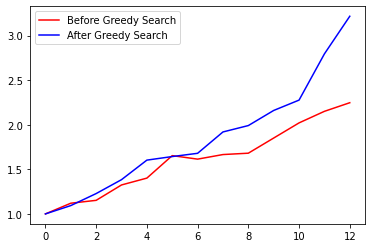

In [258]:
#Greedy Search

Solution = GenerateRandomSolution(Nassets)
print("Initial random selection:")
print(Solution, EvaluateSolution(Solution, Chart))
print("")

selected_charts = list()
for i in range(Nassets):
    if Solution[i] == 1:
        selected_charts.append(Chart[i])
portfolioChart = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")

Energies = list()
for iasset in range(Nassets):
    h = hi(SR_list, pairwise_corr, iasset)
    energyTuple = [-1*abs(h), h , iasset]
    Energies.append(energyTuple)

NGreedyLoop = 10
for i in range(NGreedyLoop):
    heapq.heapify(Energies)

    ntry = 0
    #print(Energies)
    while(ntry < len(Energies)):
        x, e, i = heapq.heappop(Energies)
        if e > 0:
            Solution[i] = -1.
        else:
            Solution[i] = 1.
        for ie in Energies:
            n = ie[2]
            ie[1] = ie[1] + Solution[i]*(jij(pairwise_corr, i, n) + jij(pairwise_corr, n, i))
            ie[0] = -ie[1]
        ntry+=1
    #heapq.heapify(Energies)

print("Selection After Greedy Search:")
print(Solution, EvaluateSolution(Solution, Chart))
print("")

selected_charts2 = list()
for i in range(Nassets):
    if Solution[i] == 1:
        selected_charts2.append(Chart[i])
portfolioChart2 = np.mean(selected_charts2, axis=0)
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.legend()
plt.show()

続いては遺伝的アルゴリズムで、ランダムに生成した複数のポートフォリオから良いものを選択して、その良いポートフォリオをもとで次の世代のポートフォリオを生成する。次の世代のポートフォリオは前の世代のポートフォリオにランダムな変更を加える突然変異と、ポートフォリオ間の遺伝子を交換させるなどで生成できる。ここでは銘柄数が比較的に小さいため、突然変異のみを考えていて、遺伝子間の交換や交配を行わなかった。
結果を比較することで、ラスト世代が第一世代よりもパフォーマンスが良くなっていることを観測できる。ただし、ここで試行した世代数が限られているため、パフォーマンスが改善されないまたは改善が小さい場合もある。

Best Gene 1st generation:
[ 1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1
 -1  1 -1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1  1 -1] 1.4094733379871998

Best Gene last generation:
[ 1 -1 -1 -1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1
  1 -1 -1 -1  1 -1  1  1  1  1  1  1 -1  1 -1  1 -1 -1  1  1  1  1  1 -1] 1.5051894789142686



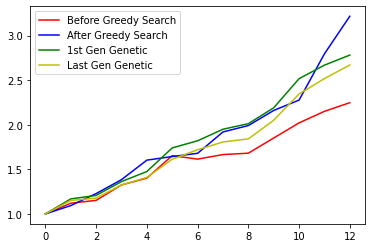

In [262]:
#Genetic Algorithm
Ngenes = 10
NGenerations = 5
Genes = list()
for i in range(Ngenes):
    gene = GenerateRandomSolution(Nassets)
    geneSR = EvaluateSolution(gene, Chart)
    Genes.append([geneSR, gene])
Genes = sorted(Genes,reverse=True)
print("Best Gene 1st generation:")
print(Genes[0][1], EvaluateSolution(Genes[0][1], Chart))
print("")

selected_charts3 = list()
for i in range(Nassets):
    if Genes[0][1][i] == 1:
        selected_charts3.append(Chart[i])
portfolioChart3 = np.mean(selected_charts3, axis=0)


K_best = 5
Ndescendants = 2
MaxMutation = 2
for iIter in range(NGenerations):
    selected_Genes = Genes[:K_best]
    for gene in selected_Genes:
        Descendants = CreateDescendant(gene[1], Ndescendants, MaxMutation)
        for Descendant in Descendants:
            DescendantSR = EvaluateSolution(Descendant, Chart)
            selected_Genes.append([DescendantSR, Descendant])
    selected_Genes = sorted(selected_Genes, key=lambda x: x[0], reverse=True)
    selected_Genes = copy.deepcopy(selected_Genes[:K_best])

print("Best Gene last generation:")
print(selected_Genes[0][1], EvaluateSolution(selected_Genes[0][1], Chart))
print("")
selected_charts4 = list()
for i in range(Nassets):
    if selected_Genes[0][1][i] == 1:
        selected_charts4.append(Chart[i])
portfolioChart4 = np.mean(selected_charts4, axis=0)

plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.plot(list(range(13)), portfolioChart3,color="g",label="1st Gen Genetic")
plt.plot(list(range(13)), portfolioChart4,color="y",label="Last Gen Genetic")
plt.legend()
plt.show()


量子アニーリングで解くために、貪欲サーチで得られたスピン形式の結果をアニーリングに使える形式に変換する。

In [245]:
def ConvertSolutionToQuboState(solution):
    output = list()
    for i in range(len(solution)):
        if solution[i] == 1:
            output.append(1)
        else: output.append(0)
    return output

QA_init_state = ConvertSolutionToQuboState(Solution)
print(QA_init_state)
    

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


### 普通のQuantum Annealingの解法

先ほど作っていたIsingをそのままQUBOに落としてこんで量子アニーリングのシミュレーターで動かしてみる。

<class 'numpy.ndarray'>


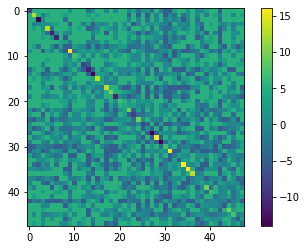

With initialisationL:
[([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 12., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 12., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 12., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 12., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 12., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 12., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [246]:
from openjij import SQASampler
sampler = SQASampler()

#pairwise_corr = CreateCorrMat(Chart)
#SR_list = list()
#for asset in Chart:
#    SR_list.append(CalculateSharpeRatio(asset))

#Bucketの翻訳
#    SRBucket(SR_list)
#    CorrelationBucket(pairwise_corr)
#    #print(pairwise_corr)

QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = pairwise_corr[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

print(type(QUBO))
import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

print('With initialisationL:')
sampleset = sampler.sample_qubo(QUBO,num_reads=10, initial_state=QA_init_state)
print(sampleset.record)

#With out initilisation
print("")
print('Without initialisation:')
sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

### Reverse Quantum Annealingの場合

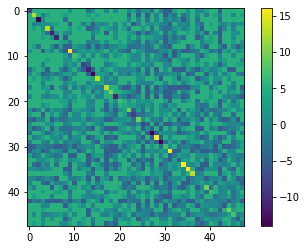

[([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], -183., 1)
 ([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], -183., 1)
 ([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0], -183., 1)
 ([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], -183., 1)
 ([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], -183., 1)
 ([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], -183., 1)
 ([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0

In [247]:
sampler = SQASampler()

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]


#for Nassets in NassetsList:
#
#    #相関係数などの準備
#    Chart = CreateAssets(Nassets)
#    pairwise_corr = CreateCorrMat(Chart)
#    SR_list = list()
#    for asset in Chart:
#        SR_list.append(CalculateSharpeRatio(asset))
#
#    #Bucketの翻訳
#    SRBucket(SR_list)
#    CorrelationBucket(pairwise_corr)
#    #print(pairwise_corr)


QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in  range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = pairwise_corr[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]
    
import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

#    print("")
#    init_state = best_forword
#    print(init_state)
#    sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10, schedule=schedule, initial_state = init_state)
#    print(sampleset_RQA.record)

[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], -88., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -53., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -6., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]


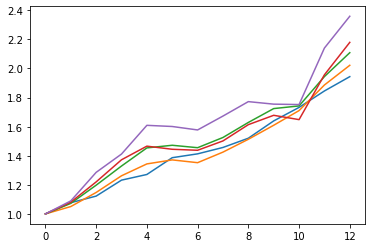

In [248]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 5
TargetS = 0.38
ReverseStep = (1.0 - TargetS) / NReverseStep
beta = 0.5
MC_step = 15
#Reverse Step
#for i in range(NReverseStep):
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, beta, MC_step]
    RQAschedule.append(step_sche)   

init_state = sampleset.record[0][0]
#init_state = None
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
for step in RQAschedule:
    selected_charts = list()
    for i in range(Nassets):
        if init_state[i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart)
    
    sche = [step]
    sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=1, reinitialize_state=False)
    init_state= sampleset_RQA.record[0][0]
    print(sampleset_RQA.record)
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=1, reinitialize_state=False)
#print(sampleset_RQA.record)
pause_initial_state = sampleset_RQA.record[0][0]

[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]


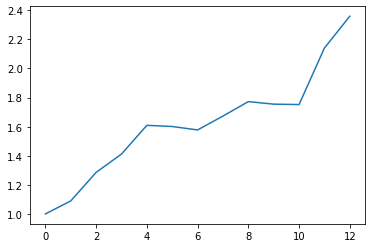

In [249]:
#Create Pause Step
RQAschedule = []
NPauseStep = 5
TargetS = 0.38
beta = 5.0
MC_step = 50
step_sche = [TargetS, beta, MC_step*NPauseStep]
RQAschedule.append(step_sche)

init_state = pause_initial_state
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
for step in RQAschedule:
    selected_charts = list()
    for i in range(Nassets):
        if init_state[i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart)
    
    sche = [step]
    sampleset_RQA = sampler.sample_qubo(QUBO, schedule=sche, initial_state = init_state, num_reads=1, reinitialize_state=False)
    init_state= sampleset_RQA.record[0][0]
    print(sampleset_RQA.record)
forward_initial_state = sampleset_RQA.record[0][0]


[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

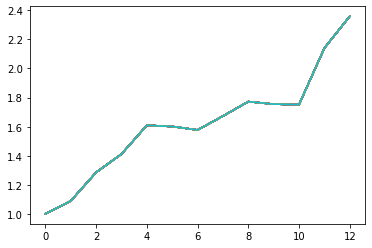

In [250]:
#Create Forward Step
RQAschedule = []
NForwardStep = 50
TargetS = 0.38
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 5.0
MC_step = 5

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, beta, MC_step]
    RQAschedule.append(step_sche)

init_state = forward_initial_state
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
for step in RQAschedule:
    selected_charts = list()
    for i in range(Nassets):
        if init_state[i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart)
    
    sche = [step]
    sampleset_RQA = sampler.sample_qubo(QUBO, schedule=sche, initial_state = init_state, num_reads=1, reinitialize_state=False)
    init_state= sampleset_RQA.record[0][0]
    print(sampleset_RQA.record)
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule.reverse(), initial_state = init_state, num_reads=5, reinitialize_state=False)
#print(sampleset_RQA.record)

print("")
straight = sampler.sample_qubo(QUBO,num_reads=1,initial_state =forward_initial_state)
print(straight.record)

[0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 1 1 0]
[0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 1 1 0]
[([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], -183., 1)]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -24., 1)]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], -5., 1)]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0]
[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0

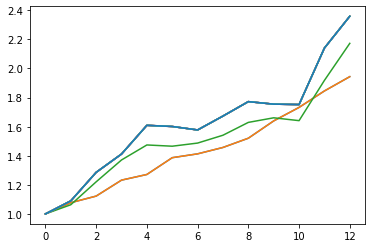

In [251]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 5
NPauseStep = 5
NForwardStep = 5
TargetS = 0.38
ReverseStep = (1.0 - TargetS) / NReverseStep
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 10.
#Reverse Step
#for i in range(NReverseStep):
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, 100., 5]
    RQAschedule.append(step_sche)   

#Pause Step
RQAschedule.append([TargetS, 5.0, NPauseStep*10])

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, 4.8, 50]
    #step_sche = [1.0, 5.0 , 10]
    RQAschedule.append(step_sche)

init_state = sampleset.record[0][0]
#init_state = None
print(init_state)
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
for step in RQAschedule:
    selected_charts = list()
    for i in range(Nassets):
        if init_state[i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart)
    
    sche = [step]
    sampleset_RQA = sampler.sample_qubo(QUBO, schedule=sche, initial_state = init_state, num_reads=1, reinitialize_state=False)
    init_state= sampleset_RQA.record[0][0]
    print(init_state)

    print(sampleset_RQA.record)

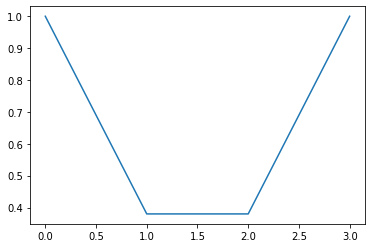

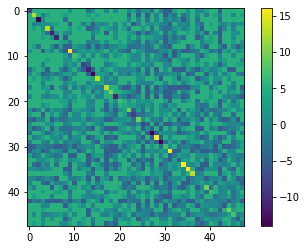

[([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0], -154., 1, 0.        )
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0], -147., 1, 0.        )
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0], -145., 1, 0.        )
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], -131., 1, 0.        )
 ([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0], -130., 1, 0.        )
 ([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0], -1

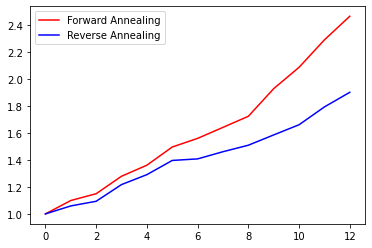

In [252]:
from openjij import SQASampler
from dwave.system import DWaveSampler, EmbeddingComposite
#sampler = SQASampler()

token = '****'
endpoint = 'https://cloud.dwavesys.com/sapi/'

dw_sampler = DWaveSampler(solver='Advantage_system4.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]


# RQA schedule
timing = (0,1,2,3)
Ratio = (1.0,0.38,0.38,1.0)
schedule = list(zip(timing,Ratio))
plt.plot(timing,Ratio)
plt.show()


#for Nassets in NassetsList:
#
#    #相関係数などの準備
#    Chart = CreateAssets(Nassets)
#    pairwise_corr = CreateCorrMat(Chart)
#    SR_list = list()
#    for asset in Chart:
#        SR_list.append(CalculateSharpeRatio(asset))
#
#    #Bucketの翻訳
#    SRBucket(SR_list)
#    CorrelationBucket(pairwise_corr)
#    #print(pairwise_corr)
#

QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in  range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = pairwise_corr[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

min_forword = 0
for result in sampleset.record:
    if result[1] < min_forword:
        min_forword = result[1]
        best_forword = result[0]
    
selected_charts = list()
for i in range(Nassets):
    if best_forword[i]:
        selected_charts.append(Chart[i])
portfolioChart = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart,color="r",label="Forward Annealing")

#    print("")
#init_state = best_forword
#    print(init_state)
sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10,  anneal_schedule=schedule, initial_state = QA_init_state)
print(sampleset_RQA.record)

min_RQA = 0
for result in sampleset_RQA.record:
    if result[1] < min_RQA:
        min_RQA = result[1]
        best_RQA = result[0]
selected_charts = list()
for i in range(Nassets):
    if best_RQA[i]:
        selected_charts.append(Chart[i])
portfolioChart = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart,color="b",label="Reverse Annealing")
plt.legend()
plt.show()


## 参考文献
1. Harry Markowitz, "Portfolio selection", The journal of finance, 7(1):77–91 (1952)
2. Davide Venturelli, Alexei Kondratyev, "Reverse Quantum Annealing Approach to Portfolio Optimization Problems", Quantum Machine Intelligence volume 1, pages17–30 (2019)
